In [17]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import re
from gensim.models import word2vec
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tempfile
import subprocess
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

RandomSeed = 42
np.random.seed(RandomSeed)


pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)
sns.set(font_scale = 1.2)

AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']



def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    
    return entropy




def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    #IDR_seq = AAs[IDR_residues].str.cat()
  
    return len(IDR_residues), #IDR_seq


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count


def phys_features(sequence):
   # Evaluate sequence specific parameters that the model uses:
    df = pd.DataFrame({'Sequence' : [sequence]})
    df['Sequence_length'] = df['Sequence'].str.len()
    df['Hydrophobicity'] = hydrophobicity(str(df['Sequence']))
    df['Shannon_entropy'] = Shannon_entropy(str(df['Sequence'])) 
    IDR_reg = extract_IDR(df['Sequence'].item())
    #df['IDR_sequence']  = IDR_reg[1]
    df['IDR_fraction']  = IDR_reg/ df['Sequence_length']
    

    
    return df



In [18]:
with open('w2v.pkl', 'rb') as f:
    w2v = pickle.load(f)
with open('phys_feat.pkl', 'rb') as f:
    phys_feat = pickle.load(f)

In [19]:
df1 = pd.read_excel('uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.xlsx')
df1.index = df1['Entry']
df1 = df1.drop(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Status', 'Gene ontology (biological process)', 'Gene ontology (cellular component)', 'Gene ontology (molecular function)'], axis=1)

In [20]:
w2v_df=df1.loc[w2v]
phys_feat_df = df1.loc[phys_feat]
w2v_df

,Sequence,Gene ontology (GO),Gene ontology IDs
Entry,,,
Q9GZS1,MAAEVLPSARWQYCGAPDGSQRAVLVQFSNGKLQSPGNMRFTLYENKDSTNPRKRNQRILAAETDRLSYVGNNFGTGALKCNTLCRHFVGILNKTSGQMEVYDAELFNMQPLFSDVSVESELALESQTKTYREKMDSCIEAFGTTKQKRALNTRRMNRVGNESLNRAVAKAAETIIDTKGVTALVSDAIHNDLQDDSLYLPPCYDDAAKPEDVYKFEDLLSPAEYEALQSPSEAFRNVTSEEILKMIEENSHCTFVIEALKSLPSDVESRDRQARCIWFLDTLIKFRAHRVVKRKSALGPGVPHIINTKLLKHFTCLTYNNGRLRNLISDSMKAKITAYVIILALHIHDFQIDLTVLQRDLKLSEKRMMEIAKAMRLKISKRRVSVAAGSEEDHKLGTLSLPLPPAQTSDRLAKRRKIT,"fibrillar center [GO:0001650]; host cell nucleus [GO:0042025]; nucleolus [GO:0005730]; nucleoplasm [GO:0005654]; RNA polymerase I complex [GO:0005736]; DNA binding [GO:0003677]; DNA-directed 5'-3' RNA polymerase activity [GO:0003899]; RNA polymerase I general transcription initiation factor binding [GO:0001179]; nucleolar large rRNA transcription by RNA polymerase I [GO:0042790]; positive regulation of gene expression, epigenetic [GO:0045815]; RNA polymerase I preinitiation complex assembly [GO:0001188]; termination of RNA polymerase I transcription [GO:0006363]; transcription elongation from RNA polymerase I promoter [GO:0006362]; transcription initiation from RNA polymerase I promoter [GO:0006361]",GO:0001179; GO:0001188; GO:0001650; GO:0003677; GO:0003899; GO:0005654; GO:0005730; GO:0005736; GO:0006361; GO:0006362; GO:0006363; GO:0042025; GO:0042790; GO:0045815
Q14974,MELITILEKTVSPDRLELEAAQKFLERAAVENLPTFLVELSRVLANPGNSQVARVAAGLQIKNSLTSKDPDIKAQYQQRWLAIDANARREVKNYVLQTLGTETYRPSSASQCVAGIACAEIPVNQWPELIPQLVANVTNPNSTEHMKESTLEAIGYICQDIDPEQLQDKSNEILTAIIQGMRKEEPSNNVKLAATNALLNSLEFTKANFDKESERHFIMQVVCEATQCPDTRVRVAALQNLVKIMSLYYQYMETYMGPALFAITIEAMKSDIDEVALQGIEFWSNVCDEEMDLAIEASEAAEQGRPPEHTSKFYAKGALQYLVPILTQTLTKQDENDDDDDWNPCKAAGVCLMLLATCCEDDIVPHVLPFIKEHIKNPDWRYRDAAVMAFGCILEGPEPSQLKPLVIQAMPTLIELMKDPSVVVRDTAAWTVGRICELLPEAAINDVYLAPLLQCLIEGLSAEPRVASNVCWAFSSLAEAAYEAADVADDQEEPATYCLSSSFELIVQKLLETTDRPDGHQNNLRSSAYESLMEIVKNSAKDCYPAVQKTTLVIMERLQQVLQMESHIQSTSDRIQFNDLQSLLCATLQNVLRKVQHQDALQISDVVMASLLRMFQSTAGSGGVQEDALMAVSTLVEVLGGEFLKYMEAFKPFLGIGLKNYAEYQVCLAAVGLVGDLCRALQSNIIPFCDEVMQLLLENLGNENVHRSVKPQILSVFGDIALAIGGEFKKYLEVVLNTLQQASQAQVDKSDYDMVDYLNELRESCLEAYTGIVQGLKGDQENVHPDVMLVQPRVEFILSFIDHIAGDEDHTDGVVACAAGLIGDLCTAFGKDVLKLVEARPMIHELLTEGRRSKTNKAKTLATWATKELRKLKNQA,cytoplasm [GO:0005737]; cytoplasmic stress granule [GO:0010494]; cytosol [GO:0005829]; endoplasmic reticulum tubular network [GO:0071782]; extracellular exosome [GO:0070062]; extracellular region [GO:0005576]; ficolin-1-rich granule lumen [GO:1904813]; host cell [GO:0043657]; membrane [GO:0016020]; nuclear envelope [GO:0005635]; nuclear membrane [GO:0031965]; nuclear pore [GO:0005643]; nucleoplasm [GO:0005654]; nucleus [GO:0005634]; specific granule lumen [GO:0035580]; enzyme binding [GO:0019899]; Hsp90 protein binding [GO:0051879]; importin-alpha family protein binding [GO:0061676]; nuclear import signal receptor activity [GO:0061608]; nuclear localization sequence binding [GO:0008139]; protein domain specific binding [GO:0019904]; Ran GTPase binding [GO:0008536]; RNA binding [GO:0003723]; zinc ion binding [GO:0008270]; apoptotic DNA fragmentation [GO:0006309]; astral microtubule organization [GO:0030953]; establishment of mitotic spindle localization [GO:0040001]; establishment of protein localization [GO:0045184]; intracellular transport of virus [GO:0075733]; mitotic chromosome movement towards spindle pole [GO:0007079]; mitotic metaphase plate congression [GO:0007080]; mitotic spindle assembly [GO:0090307]; modulation by virus of host cellular process [GO:0019054]; neutrophil degranulation [GO:0043312]; NLS-bearing protein import into nucleus [GO:0006607]; protein import into nucleus [GO:0006606]; Ran protein signal transduction [GO:0031291]; regulation of cholesterol biosynthetic process [GO:0045540]; ribosomal protein import into nucleus [GO:0006610],GO:0003723; GO:0005576; GO:0005634; GO:0005635; GO:0005643; GO:0005654; GO:0005737; GO:0005829; GO:0006309; GO:0006606; GO:0006607; GO:0006610; GO:0007079; GO:0007080; GO:

In [21]:
sequences = w2v_df['Sequence'].tolist()
sequences1 = phys_feat_df['Sequence'].tolist()

In [22]:
temp_c = [phys_features(t) for t in sequences]
temp_c_df = pd.concat(temp_c)
temp_c_df.index = w2v_df.index
temp_c_df

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction
Entry,,,,,
Q9GZS1,MAAEVLPSARWQYCGAPDGSQRAVLVQFSNGKLQSPGNMRFTLYENKDSTNPRKRNQRILAAETDRLSYVGNNFGTGALKCNTLCRHFVGILNKTSGQMEVYDAELFNMQPLFSDVSVESELALESQTKTYREKMDSCIEAFGTTKQKRALNTRRMNRVGNESLNRAVAKAAETIIDTKGVTALVSDAIHNDLQDDSLYLPPCYDDAAKPEDVYKFEDLLSPAEYEALQSPSEAFRNVTSEEILKMIEENSHCTFVIEALKSLPSDVESRDRQARCIWFLDTLIKFRAHRVVKRKSALGPGVPHIINTKLLKHFTCLTYNNGRLRNLISDSMKAKITAYVIILALHIHDFQIDLTVLQRDLKLSEKRMMEIAKAMRLKISKRRVSVAAGSEEDHKLGTLSLPLPPAQTSDRLAKRRKIT,419,-174.2,3.930991,0.000000
Q14974,MELITILEKTVSPDRLELEAAQKFLERAAVENLPTFLVELSRVLANPGNSQVARVAAGLQIKNSLTSKDPDIKAQYQQRWLAIDANARREVKNYVLQTLGTETYRPSSASQCVAGIACAEIPVNQWPELIPQLVANVTNPNSTEHMKESTLEAIGYICQDIDPEQLQDKSNEILTAIIQGMRKEEPSNNVKLAATNALLNSLEFTKANFDKESERHFIMQVVCEATQCPDTRVRVAALQNLVKIMSLYYQYMETYMGPALFAITIEAMKSDIDEVALQGIEFWSNVCDEEMDLAIEASEAAEQGRPPEHTSKFYAKGALQYLVPILTQTLTKQDENDDDDDWNPCKAAGVCLMLLATCCEDDIVPHVLPFIKEHIKNPDWRYRDAAVMAFGCILEGPEPSQLKPLVIQAMPTLIELMKDPSVVVRDTAAWTVGRICELLPEAAINDVYLAPLLQCLIEGLSAEPRVASNVCWAFSSLAEAAYEAADVADDQEEPATYCLSSSFELIVQKLLETTDRPDGHQNNLRSSAYESLMEIVKNSAKDCYPAVQKTTLVIMERLQQVLQMESHIQSTSDRIQFNDLQSLLCATLQNVLRKVQHQDALQISDVVMASLLRMFQSTAGSGGVQEDALMAVSTLVEVLGGEFLKYMEAFKPFLGIGLKNYAEYQVCLAAVGLVGDLCRALQSNIIPFCDEVMQLLLENLGNENVHRSVKPQILSVFGDIALAIGGEFKKYLEVVLNTLQQASQAQVDKSDYDMVDYLNELRESCLEAYTGIVQGLKGDQENVHPDVMLVQPRVEFILSFIDHIAGDEDHTDGVVACAAGLIGDLCTAFGKDVLKLVEARPMIHELLTEGRRSKTNKAKTLATWATKELRKLKNQA,876,-84.6,4.022479,0.000000
Q9NVM4,MKIFCSRANPTTGSVEWLEEDEHYDYHQEIARSSYADMLHDKDRNVKYYQGIRAAVSRVKDRGQKALVLDIGTGTGLLSMMAVTAGADFCYAIEVFKPMADAAVKIVEKNGFSDKIKVINKHSTEVTVGPEGDMPCRANILVTELFDTELIGEGALPSYEHAHRHLVEENCEAVPHRATVYAQLVESGRMWSWNKLFPIHVQTSLGEQVIVPPVDVESCPGAPSVCDIQLNQVSPADFTVLSDVLPMFSIDFSKQVSSSAACHSRRFEPLTSGRAQVVLSWWDIEMDPEGKIKCTMAPFWAHSDPEEMQWRDHWMQCVYFLPQEEPVVQGSALYLVAHHDDYCVWYSLQRTSPEKNERVRQMRPVCDCQAHLLWNRPRFGEINDQDRTDRYVQALRTVLKPDSVCLCVSDGSLLSVLAHHLGVEQVFTVESSAASHKLLRKIFKANHLEDKINIIEKRPELLTNEDLQGRKVSLLLGEPFFTTSLLPWHNLYFWYVRTAVDQHLGPGAMVMPQAASLHAVVVEFRDLWRIRSPCGDCEGFDVHIMDDMIKRALDFRESREAEPHPLWEYPCRSLSEPWQILTFDFQQPVPLQPLCAEGTVELRRPGQSHAAVLWMEYHLTPECTLSTGLLEPADPEGGCCWNPHCKQAVYFFSPAPDPRALLGGPRTVSYAVEFHPDTGDIIMEFRHADTPD,692,-197.0,4.083571,0.000000
P62310,MADDVDQQQTTNTVEEPLDLIRLSLDERIYVKMRNDRELRGRLHAYDQHLNMILGDVEETVTTIEIDEETYEEIYKSTKRNIPMLFVRGDGVVLVAPPLRVG,102,-54.1,3.299157,0.000000
Q9Y333,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVTDPEKYPHMLSVKNCFIRGSVVRYVQLPADEVDTQLLQDAARKEALQQKQ,95,-15.0,3.324463,0.000000
P62312,MSLRKQTPSDFLKQIIGRPVVVKLNSGVDYRGVLACLDGYMNIALEQTEEYVNGQLKNKYGDAFIRGNNVLYISTQKRRM,80,-34.0,3.216505,0.000000
P63165,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGGHSTV,101,-96.8,3.357594,0.237624
Q9Y4Y9,MAANATTNPSQLLPLELVDKCIGSRIHIVMKSDKEIVGTLLGFDDFVNMVLEDVTEFEITPEGRRITKLDQILLNGNNITMLVPGGEGPEV,91,3.2,3.239256,0.000000
P52597,MMLGPEGGEGFVVKLRGLPWSCSVEDVQNFLSDCTIHDGAAGVHFIYTREGRQSGEAFVELGSEDDVKMALKKDRESMGHRYIEVFKSHRTEMDWVLKHSGPNSADSANDGFVRLRGLPFGCTKEEIVQFFSGLEIVPNGITLPVDPEGKITGEAFVQFASQELAEKALGKHKERIGHRYIEVFKSSQEEVRSYSDPPLKFMSVQRPGPYDRPGTARRYIGIVKQAGLERMRPGAYSTGYGGYEEYSGLSDGYGFTTDLFGRDLSYCLSGMYDHRYGDSEFTVQSTTGHCVHMRGLPYKATENDIYNFFSPLNPVRVHIEIGPDGRVTGEADVEFATHEEAVAAMSKDRANMQHRYIELFLNSTTGASNGAYSSQVMQGMGVSAAQATYSGLESQSVSGCYGAGYSGQNSMGGYD,415,-200.0,3.927279,0.000000


In [23]:
temp_d = [phys_features(t) for t in sequences1]
temp_d_df = pd.concat(temp_d)
temp_d_df.index = phys_feat_df.index
temp_d_df

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction
Entry,,,,,
P50750,MAKQYDSVECPFCDEVSKYEKLAKIGQGTFGEVFKARHRKTGQKVALKKVLMENEKEGFPITALREIKILQLLKHENVVNLIEICRTKASPYNRCKGSIYLVFDFCEHDLAGLLSNVLVKFTLSEIKRVMQMLLNGLYYIHRNKILHRDMKAANVLITRDGVLKLADFGLARAFSLAKNSQPNRYTNRVVTLWYRPPELLLGERDYGPPIDLWGAGCIMAEMWTRSPIMQGNTEQHQLALISQLCGSITPEVWPNVDNYELYEKLELVKGQKRKVKDRLKAYVRDPYALDLIDKLLVLDPAQRIDSDDALNHDFFWSDPMPSDLKGMLSTHLTSMFEYLAPPRRKGSQITQQSTNQSRNPATTNQTEFERVF,372,-143.8,3.954583,0.069892
Q92966,MAEGSRGGPTCSGVGGRQDPVSGSGGCNFPEYELPELNTRAFHVGAFGELWRGRLRGAGDLSLREPPASALPGSQAADSDREDAAVARDLDCSLEAAAELRAVCGLDKLKCLEDGEDPEVIPENTDLVTLGVRKRFLEHREETITIDRACRQETFVYEMESHAIGKKPENSADMIEEGELILSVNILYPVIFHKHKEHKPYQTMLVLGSQKLTQLRDSIRCVSDLQIGGEFSNTPDQAPEHISKDLYKSAFFYFEGTFYNDKRYPECRDLSRTIIEWSESHDRGYGKFQTARMEDFTFNDLCIKLGFPYLYCHQGDCEHVIVITDIRLVHHDDCLDRTLYPLLIKKHWLWTRKCFVCKMYTARWVTNNDSFAPEDPCFFCDVCFRMLHYDSEGNKLGEFLAYPYVDPGTFN,411,-189.9,3.980755,0.055961
P04792,MTERRVPFSLLRGPSWDPFRDWYPHSRLFDQAFGLPRLPEEWSQWLGGSSWPGYVRPLPPAAIESPAVAAPAYSRALSRQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITGKHEERQDEHGYISRCFTRKYTLPPGVDPTQVSSSLSPEGTLTVEAPMPKLATQSNEITIPVTFESRAQLGGPEAAKSDETAAK,205,-120.5,3.675881,0.282927
Q9Y4Z0,MLPLSLLKTAQNHPMLVELKNGETYNGHLVSCDNWMNINLREVICTSRDGDKFWRMPECYIRGSTIKYLRIPDEIIDMVKEEVVAKGRGRGGLQQQKQQKGRGMGGAGRGVFGGRGRGGIPGTGRGQPEKKPGRQAGKQ,139,-108.2,3.509798,0.388489
P98179,MSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDN,157,-175.2,3.370396,0.496815
P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPEELGAEEEMEAGRPRPVLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQERIAHQRMGD,213,-169.7,3.641715,0.309859
Q96LA8,MSQPKKRKLESGGGGEGGEGTEEEDGAEREAALERPRRTKRERDQLYYECYSDVSVHEEMIADRVRTDAYRLGILRNWAALRGKTVLDVGAGTGILSIFCAQAGARRVYAVEASAIWQQAREVVRFNGLEDRVHVLPGPVETVELPEQVDAIVSEWMGYGLLHESMLSSVLHARTKWLKEGGLLLPASAELFIAPISDQMLEWRLGFWSQVKQHYGVDMSCLEGFATRCLMGHSEIVVQGLSGEDVLARPQRFAQLELSRAGLEQELEAGVGGRFRCSCYGSAPMHGFAIWFQVTFPGGESEKPLVLSTSPFHPATHWKQALLYLNEPVQVEQDTDVSGEITLLPSRDNPRRLRVLLRYKVGDQEEKTKDFAMED,375,-138.0,3.861519,0.101333
Q9NYH9,MAEIIQERIEDRLPELEQLERIGLFSHAEIKAIIKKASDLEYKIQRRTLFKEDFINYVQYEINLLELIQRRRTRIGYSFKKDEIENSIVHRVQGVFQRASAKWKDDVQLWLSYVAFCKKWATKTRLSKVFSAMLAIHSNKPALWIMAAKWEMEDRLSSESARQLFLRALRFHPECPKLYKEYFRMELMHAEKLRKEKEEFEKASMDVENPDYSEEILKGELAWIIYKNSVSIIKGAEFHVSLLSIAQLFDFAKDLQKEIYDDLQALHTDDPLTWDYVARRELEIESQTEEQPTTKQAKAVEVGRKEERCCAVYEEAVKTLPTEAMWKCYITFCLERFTKKSNSGFLRGKRLERTMTVFRKAHELKLLSECQYKQLSVSLLCYNFLREALEVAVAGTELFRDSGTMWQLKLQVLIESKSPDIAMLFEEAFVHLKPQVCLPLWISWAEWSEGAKSQEDTEAVFKKALLAVIGADSVTLKNKYLDWAYRSGGYKKARAVFKSLQESRPFSVDFFRKMIQFEKEQESCNMANIREYYERALREFGSADSDLWMDYMKEELNHPLGRPENCGQIYWRAMKMLQGESAEAFVAKHAMHQTGHL,597,-268.2,3.978211,0.000000


In [24]:
w2v_df1 = w2v_df.merge(temp_c_df)
w2v_df1 = w2v_df1.drop(['Hydrophobicity', 'Shannon_entropy', 'Sequence_length', 'Sequence', 'Gene ontology IDs'], axis=1)
w2v_df1.index = w2v_df.index
w2v_IDR = w2v_df1.drop(['Gene ontology (GO)'], axis = 1)
w2v_IDR['type'] = 'w2v'
w2v_IDR = w2v_IDR.reset_index()
w2v_IDR.index = w2v_IDR['type']
w2v_IDR = w2v_IDR.drop(['type'], axis = 1)
w2v_IDR = w2v_IDR.sort_values(by=['IDR_fraction'], ascending = False)

In [25]:
phys_feat_df1 = phys_feat_df.merge(temp_d_df)
phys_feat_df1 = phys_feat_df1.drop(['Hydrophobicity', 'Shannon_entropy', 'Sequence_length'], axis=1)
phys_feat_df1.index = phys_feat_df.index
phys_feat_IDR = phys_feat_df1.drop(['Sequence', 'Gene ontology (GO)', 'Gene ontology IDs'], axis=1)
phys_feat_IDR['type'] = 'phys_feat'
phys_feat_IDR = phys_feat_IDR.reset_index()
phys_feat_IDR.index = phys_feat_IDR['type']
phys_feat_IDR = phys_feat_IDR.drop(['type'], axis = 1)
phys_feat_IDR = phys_feat_IDR.sort_values(by=['IDR_fraction'], ascending = False)


In [26]:
frames = [phys_feat_IDR, w2v_IDR]

result = pd.concat(frames)
result.to_csv('IDR_comparison.csv')

In [27]:
gene_ontology = w2v_df['Gene ontology (GO)'].tolist()

lst = [str(ontology).split(';') for ontology in gene_ontology]

flat_list = []
for sublist in lst:
    for item in sublist:
        flat_list.append(item)

flat_list = list(map(str.lstrip, flat_list))

flat_list1 =[]
for line in flat_list:
    line = line.split(' [')[0]
    flat_list1.append(line)

a = pd.Series(Counter(flat_list1))

In [28]:
b = a.to_frame()
b.columns = ['frequency']
b.index.name = 'gene ontology'
b['fraction of proteins w2v'] = (b['frequency']/16)*100
b = b.sort_values('fraction of proteins w2v', ascending = False)
b = b.drop(['frequency'], axis =1)
b

,fraction of proteins w2v
gene ontology,
nucleoplasm,87.50
nucleus,81.25
cytosol,81.25
cytoplasm,56.25
RNA binding,56.25
...,...
synapse,6.25
XY body,6.25
potassium channel regulator activity,6.25


In [29]:
gene_ontology1 = phys_feat_df['Gene ontology (GO)'].tolist()

lst1 = [str(ontology).split(';') for ontology in gene_ontology1]

flat_list2 = []
for sublist in lst1:
    for item in sublist:
        flat_list2.append(item)

flat_list2 = list(map(str.lstrip, flat_list2))

flat_list3 =[]
for line in flat_list2:
    line = line.split(' [')[0]
    flat_list3.append(line)

d = pd.Series(Counter(flat_list3))

In [30]:
e = d.to_frame()
e.columns = ['frequency']
e.index.name = 'gene ontology'
e['fraction of proteins phys_feat'] = (e['frequency']/8)*100
e = e.drop(['frequency'], axis =1)
e = e.sort_values('fraction of proteins phys_feat', ascending = False)
e

,fraction of proteins phys_feat
gene ontology,
nucleoplasm,87.5
nucleus,87.5
nucleolus,37.5
RNA binding,37.5
membrane,37.5
...,...
spindle,12.5
Z disc,12.5
identical protein binding,12.5


In [35]:
df6 = pd.concat([b, e], axis=1)
df6

,fraction of proteins w2v,fraction of proteins phys_feat
nucleoplasm,87.50,87.5
nucleus,81.25,87.5
cytosol,81.25,37.5
cytoplasm,56.25,25.0
RNA binding,56.25,37.5
...,...,...
proteasome complex,NaN,12.5
spindle,NaN,12.5
Z disc,NaN,12.5
protein folding chaperone,NaN,12.5


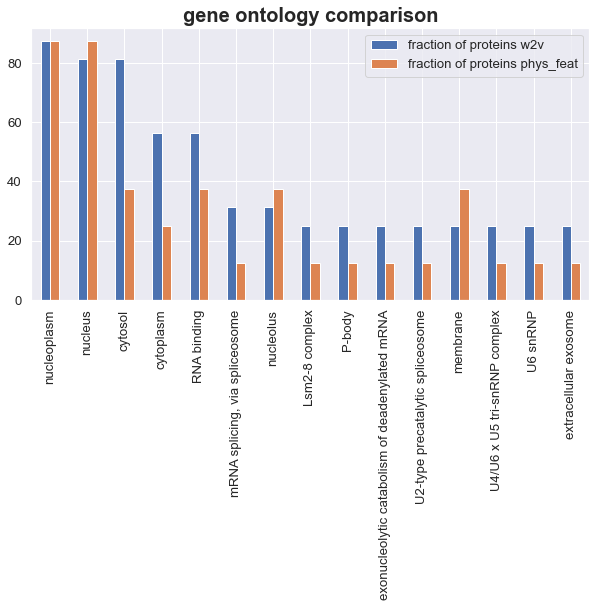

In [32]:
ax = df6.plot.bar(rot=90, figsize = (10,5))
plt.title('gene ontology comparison', fontsize=20, fontweight = 'bold')
plt.savefig('GO_comparison.png', bbox_inches='tight', pad_inches = 0.0)